In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from models.baseline_models import UniformMovingAverage, TriangularMovingAverage, ExponentialMovingAverage
from utils.plots import plot
import pandas as pd
from utils.plots import plot_time_signals
from utils.utils import shift
import scipy as sp
from utils.rolling import periodic_rolling
from IPython.display import display
from utils.data_processing import to_percentile
from utils.mutual_information_plots import plot_mi 
from utils.plots import plot_autocorr
from utils.utils import cut
from pandas.io import clipboard
import os

In [8]:
from utils.rolling import rolling_norm 

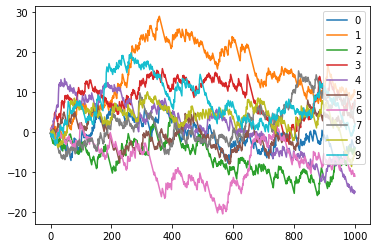

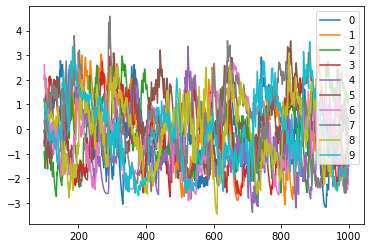

In [9]:
l = 1000
df = pd.DataFrame(np.array([np.cumsum(np.random.poisson(0.31,l)-.31) for i in range(10)]).T)
df.plot()
plt.show()

normed_df = rolling_norm(data=df,window=100,period=1, offset=0)
normed_df.plot()
plt.show()


## Thesis document figures copy pasta

In [ ]:
weekly_files = [
    name for 
    name in os.listdir('./data/processed/Totals_T168H_2001-01-04_2019-01-10_LAT41.641_42.024_'+
                       'LON-87.821_-87.525/plots')
    if name.endswith('png')
]
clipboard.copy('''
'''.join([f'''
\\begin{{figure}}
    \centering
    \includegraphics[width=0.95\\textwidth]{{\plotsweekly{{{file}}}}}
    %TODO: ADD FIGURE NAME
    \caption{{TODO: ADD FIGURE NAME}}
    \label{{fig:{file[:-4].lower()}}}
\end{{figure}}''' for file in weekly_files]))

In [65]:
daily_files = [
    name for 
    name in os.listdir('./data/processed/Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_'+
                       'LON-87.821_-87.525/plots')
    if name.endswith('png')
]
clipboard.copy('''
'''.join([f'''
\\begin{{figure}}
    \centering
    \includegraphics[width=0.95\\textwidth]{{\plotsweekly{{{file}}}}}
    %TODO: ADD FIGURE NAME
    \caption{{TODO: ADD FIGURE NAME}}
    \label{{fig:{file[:-4].lower()}}}
\end{{figure}}''' for file in daily_files]))

In [67]:
hourly_files = [
    name for 
    name in os.listdir('./data/processed/Totals_T1H_2014-01-01_2019-01-01_LAT41.641_42.024_'+
                       'LON-87.821_-87.525/plots')
    if name.endswith('png')
]
clipboard.copy('''
'''.join([f'''
\\begin{{figure}}
    \centering
    \includegraphics[width=0.95\\textwidth]{{\plotsweekly{{{file}}}}}
    %TODO: ADD FIGURE NAME
    \caption{{TODO: ADD FIGURE NAME}}
    \label{{fig:{file[:-4].lower()}}}
\end{{figure}}''' for file in hourly_files]))

In [ ]:
# sequence datasets subset selections

combined_train_valid_set = torch.utils.data.ConcatDataset([
    train_loader.dataset.dataset, 
    valid_loader.dataset.dataset,
])
combined_train_valid_loader = torch.utils.data.DataLoader(
    combined_train_valid_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)



### Percentile ranking/binning to make MI calculation more robust

In [ ]:
n = 24
a = np.sin(2*np.pi*(np.arange(24*100)%24)/24)
a[0] = np.max(a)*6
a_pct = to_percentile(a)
a_cut = cut(x=a,bins=10)
print(a_cut)

plot(
    a=a,
    a_pct=a_pct,
    a_cut=a_cut,
).show()

for bins in [0,5,100,len(np.unique(a))]:
    plot_mi(a_cut=a_cut,a_pct=a_pct,a=a, bins=bins, title=f"Auto MI ({bins})").show()
plot_autocorr(a_cut=a_cut,a_pct=a_pct,a=a).show()

In [ ]:
data = sp.stats.expon.rvs(.1*np.ones(100))
# data = sp.stats.norm.rvs(.1*np.ones(100))
data[0] = np.max(data)**2


df = pd.DataFrame(data=data, columns=['x'])
df['pct'] = df.rank(pct=True)
display(df)

X = np.unique(df.values, axis=0)
val, perc = X[:,0], X[:,1]

plt.bar(x=val,height=perc)
plt.show()

### Estimated Maximum Prediction Gain
Periodic signals - signal can be predicted with constant accuracy regardless of interval

Normalise gaussian process
Normalise poisson process

###  Example of periodic poisson process and how well periodic average estimates the mu of the sample

In [ ]:
def get_optimal_bins(a):
    # flag anomalies of the data and set bin limits to everything withn the limits
    window =51
    period = {
        "24H":7,
        "1H": 24,
        "168H":1,
    }.get(FREQ, 1)
    thresh = 3
    period = 1
    
    anoms = flag_anomalies(
        data=a, 
        thresh=thresh,
        window=window, 
        period=period, 
        center=True,
        mode='reflect',
    )

In [ ]:
period = 24
n = period*500
window = 10
center = True
lambdas = np.ones(n)*.3
lambdas = .1*(np.sin(2*np.pi*(np.arange(n)%period)/period) + 1) 
# lambdas = 1*(np.arange(n)%period)/period

decay = np.exp(-1*np.linspace(0.1,1,n))
# lambdas = decay*(lambdas + 1)

date_range = pd.date_range('2020',freq='H', periods=n)

# generate sampels
summed_data = []
summed_lambdas = []
num_samples = 1

rand_w = np.random.rand(num_samples)
for i in range(num_samples):
    summed_lambdas.append(rand_w[i]*lambdas)
    data = sp.stats.poisson.rvs(rand_w[i]*lambdas)
#     data =  data + .2*(sp.stats.poisson.rvs(np.roll(data,1)) +
#                        sp.stats.poisson.rvs(np.roll(data,13)) +
#                        sp.stats.poisson.rvs(np.roll(data,19)))
    
    summed_data.append(data)
    
data = np.array(summed_data).sum(0)
lambdas = np.array(summed_lambdas).sum(0)

# data = np.cumsum(np.random.randn(n))
# data = lambdas

mu = periodic_rolling(
    func=np.mean,
    data=data,
    window=window,
    period=period,
    center=center,
    fill=np.nan,
)

std = periodic_rolling(
    func=np.std,
    data=data,
    window=window,
    period=period,
    center=center,
)

plot_time_signals(
    t_range=date_range,
    data=data, 
    lambdas=lambdas,
    mu=mu,
).show()

# test if data is normal depending on the number of underlying point process
normed_data = pd.DataFrame(data=(data-lambdas),columns=[f'Normed Data (N={num_samples})'])
normed_data = normed_data / normed_data.std()
normed_data.plot(kind='hist')
plt.show()

In [ ]:
from utils.mutual_information_plots import plot_mi_curves
from utils.plots import plot_autocorr
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
from utils.mutual_information_plots import plot_mi_curves
from utils.plots import plot_autocorr
from statsmodels.tsa.stattools import acf, pacf

nlags = 130

In [ ]:
from utils.mutual_information_plots import plot_mi_curves
from utils.plots import plot_autocorr
from statsmodels.tsa.stattools import acf, pacf

nlags = 130

plot_autocorr(data=data, max_offset=nlags).show()
plot_autocorr(data=data, max_offset=nlags, partial=True).show()

In [ ]:
mutual_info_bins = int(np.ceil(np.max(data)+1))

plot_mi_curves(
    t_range=date_range,
    a=data,
    max_offset=nlags,
    norm=True,
    log_norm=False,
    bins=int(np.ceil(np.max(data)+1)),
    temporal_variables=['Hour'],
)

## Anomoly Detection in Time series
- Low-pass filter: moving average
- Minus from original signal to get residuals
- Find outliers in residual signal outside of 3 standard deviations and mark indices
- Filter out the outliers


Have periodic moving average and std and normalise the data to detect anomolies - feeling is that std window should be longer?

In [ ]:
from utils.rolling import flag_anomalies, rolling_norm

In [ ]:
n = 2000
var = (np.sin(np.linspace(1,15,n)) + 1.5)

anoms = np.random.binomial(n=1,p=.1,size=n)
anoms[[0,-1]] = 1 # ensures we have anomalies near start and end - don't want to lose these

noise = np.random.randn(n)
process = np.cumsum(np.random.randn(n))

data = (process + noise*.1 + np.sign(np.random.randn(len(anoms)))*anoms*6)*var
data = pd.Series(data)

In [ ]:
from utils.rolling import rolling_norm
window = 21
center=True
mode='reflect'

data_normed = rolling_norm(data=data,window=window,center=center, mode=mode)

plot(
    data_normed=data_normed,
    data=data,
).show()

pd.Series(data_normed).describe()

In [ ]:
sigma_thresh = 1.7
detected = flag_anomalies(
    data=data.values,
    thresh=sigma_thresh,
    window=window,
    center=center,
    mode=mode,
)

xs = np.arange(len(data))

go.Figure(
    data=[
        go.Scatter(name='pred',x=detected,y=data[detected],  mode='markers', marker={
            'symbol':3,
            'size': 10,
        }, opacity=0.5),
        go.Scatter(name='true',x=xs[anoms > 0],y=data[anoms > 0],  mode='markers', marker={
            'symbol':4,
            'size': 10,
        }, opacity=0.5),
        go.Scatter(name='data',y=data, opacity=0.5),
        go.Scatter(name='process*var',y=process*var, opacity=0.5),
    ]
).show()


go.Figure(
    data=[
        go.Scatter(name='pred',x=detected,y=data_normed[detected],  mode='markers', marker={
            'symbol':3,
            'size': 15,
        }, opacity=0.5),
        go.Scatter(name='true',x=xs[anoms > 0],y=data_normed[anoms > 0],  mode='markers', marker={
            'symbol':4,
            'size': 15,
        }, opacity=0.5),
        go.Scatter(name='data_normed',y=data_normed, opacity=0.5),
    ],
).show()

y_pred = np.zeros_like(anoms)
y_pred[detected] = 1
y_true = anoms

from sklearn.metrics import f1_score
f1 = f1_score(
    y_true=y_true,
    y_pred=y_pred,
)

print(f"f1 => {f1:.5}")

#### Interactive Time Series Grid

In [ ]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from ipywidgets import Layout, widgets
from utils.interactive import State
from utils.interactive import interactive_crime_prediction_comparison

In [ ]:
x = np.linspace(0,10,200)
y = np.sin(x)*4 + 4
y = np.reshape(y, (len(y),1,1))
y_score = np.ones((len(y),7,5))
y_score = y_score*y + np.random.randn(*np.shape(y_score))

y_class = np.random.rand(*np.shape(y_score))
y_class[y_class > .9] = 1
y_class[y_class <= .9] = 0

t_range = pd.date_range(start='2012',periods=len(x), freq='1D')

In [ ]:
interactive_crime_prediction_comparison(y_class=y_class,
                                        y_score=y_score,
                                        t_range=t_range)

#### DET Curve

In [ ]:
import numpy as np
from utils.metrics import det_curve, plot_det_curve, DETCurvePlotter
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [ ]:
def plot_det_curve(y_class, y_score):    
    rcParams["mathtext.fontset"] = "stix"
    rcParams["font.family"] = "STIXGeneral"
    rcParams["font.size"] = "18"
        
    fig, ax = plt.subplots(figsize=(10,10))
    
    fpr, fnr, thresholds = det_curve(y_class, y_score)

    ax.plot(
        sp.stats.norm.ppf(fpr),
        sp.stats.norm.ppf(fnr),
    )
    
    ticks = [0.001, 0.01, 0.05, 0.20, 0.5, 0.80, 0.95, 0.99, 0.999]
    tick_locations = sp.stats.norm.ppf(ticks)
    tick_labels = [
        '{:.0%}'.format(s) if (100*s).is_integer() else '{:.1%}'.format(s)
        for s in ticks
    ]
    
    ax.set_title("Detection Error Tradeoff (DET) Curve")
    
    ax.set_ylabel('False Negative Rate (Miss Probability)')
    ax.set_xlabel('False Positive Rate (False Alarm Probability)')
    
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(tick_labels)
    ax.set_xlim(-3, 3)
    ax.set_yticks(tick_locations)
    ax.set_yticklabels(tick_labels)
    ax.set_ylim(-3, 3)
    
    ax.grid()
    
    
    return fig, ax
    

In [ ]:
fig, ax = plot_det_curve(y_class=np.random.randint(0,2,100),
                    y_score=np.random.rand(100))

In [ ]:
ppf = sp.stats.norm.ppf
cdf = sp.stats.norm.cdf

In [ ]:
from models.model_result import get_models_metrics


data_path = './data/processed/T24H-X850M-Y880M_2012-01-01_2019-01-01_#826/'

metrics = get_models_metrics(data_path)

In [ ]:
metrics[0]

In [ ]:
import scipy as sp

In [ ]:
from utils.metrics import plot_det_curve_

In [ ]:
det_plot = DETCurvePlotter()
for metric in metrics:
    det_plot.add_curve_(fpr=metric.det_curve.fpr,
                        fnr=metric.det_curve.fnr,
                        eer=metric.det_curve.eer,  # note this is the mean roc_score not this curves score
                        label_name=metric.model_name)
det_plot.show()  # todo - save somewhere?

In [ ]:
fig, ax = plot_det_curve_(fpr=metric.det_curve.fpr,
                          fnr=metric.det_curve.fnr, 
                          thresholds=metric.det_curve.thresholds)


In [ ]:
metrics = get_models_metrics(data_path)
fig = go.Figure(
    layout=dict(
        title_text="Detection Error Tradeoff (DET) Curve",
        title_x=0.5,
        height=650,
        #         width=650,
        #         yaxis=dict(scaleanchor="x", scaleratio=1),
        yaxis_title='False Negative Rate',
        xaxis_title='False Positive Rate',
        yaxis=dict(range=[-3,3], scaleanchor="x", scaleratio=1),
        xaxis=dict(range=[-3, 3]), #, type="log"),
        
#         yaxis=dict(type="log"),
#         xaxis=dict(type="log"),
    ),
)

for metric in metrics:
    fnr_scaled = sp.stats.norm.ppf(metric.det_curve.fnr)
    fpr_scaled = sp.stats.norm.ppf(metric.det_curve.fpr)
#     fnr_scaled = metric.det_curve.fnr*100
#     fpr_scaled = metric.det_curve.fpr*100

    fig.add_trace(
        go.Scatter(
            y=fnr_scaled,
            x=fpr_scaled,
            name=f"{metric.model_name} (EER={metric.det_curve.eer:.3f})"
        )
    )

fig

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import torch

In [ ]:
from utils.utils import by_ref, get_data_sub_paths

In [ ]:
sub_paths = by_ref("826")
sub_path = sub_paths[0]

In [ ]:
data_path = f"data/processed/{sub_path}"

In [ ]:
data_path

In [ ]:
# plot cell distributions and cells


def plot_data_dist(data):
    data = np.flatten(data)
    values, counts = np.unique(data, return_counts=True)
    
    

In [ ]:
px.data.tips()

In [ ]:
!ls 

In [ ]:
from utils.configs import BaseConf

In [ ]:
conf = BaseConf()
conf.data_path

In [ ]:
import torch

In [ ]:
device = torch.device("cuda:0")

In [ ]:
torch.cuda.is_available(), torch.cuda.is_initialized()

In [ ]:
tt = torch.rand(10,1, device=device)

In [ ]:
torch.matmul(tt.T,tt)

In [ ]:
from ipywidgets import widgets

In [ ]:
int_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=12,
    step=1,
    description='Month:',
    continuous_update=True
)


gvalue = None
def widget_callback(change):
    global gvalue
    gvalue = change

    
int_slider.observe(widget_callback, names="value")

play_button = widgets.Play(
    value=1,
    min=1,
    max=12,
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)

widgets.jslink((play_button, 'value'), (int_slider, 'value'))

widgets.VBox([
    play_button,
    int_slider,
])

In [ ]:
gvalue

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.plots import im

In [ ]:
data_sub_path = "T24H-X850M-Y880M_2012-01-01_2019-01-01"
file_location = f"./data/processed/{data_sub_path}/generated_data.npz"
if os.path.exists(file_location):
    with np.load(file_location) as zip_file:  # context helper ensures zip_file is closed
        print(list(zip_file.keys()))
        crime_grids = zip_file["crime_grids"]
        x_range = zip_file["x_range"]
        y_range = zip_file["y_range"]

In [ ]:
mean = crime_grids.mean(axis=(0,1))

grid = np.flipud(mean)


plt.figure(figsize=(10,10))
xx, yy = np.meshgrid(x_range, y_range)
plt.pcolormesh(xx, yy, grid)
plt.show()

In [ ]:
x_min, x_max = x_range[0], x_range[-1]
y_min, y_max = y_range[0], y_range[-1]

y_ticks = np.linspace(y_min, y_max, len(y_range))
x_ticks = np.linspace(x_min, x_max, len(x_range))

coords = list(map(tuple,zip(x_range, y_range)))
plt.figure(figsize=(15,15))
c = np.linspace(0.5,0.9,len(yy.flatten())) 
plt.scatter(x=xx.flatten(), y=yy.flatten(), c=c, marker='x')

plt.xticks(x_ticks,rotation=90)
plt.yticks(y_ticks,rotation=0)
plt.grid(True)
plt.show()

In [ ]:
import geopy.distance as geo

In [ ]:
xx,

In [ ]:
print((y_min,x_min),(y_max,x_max))

origin=(y_min,x_min)
def distance_meters(point1, point2):
    """
    point is a tuple of coordinates in degrees: (y,x) or (lat, lon)
    """
    distance = geo.distance(point1,point2)
    return distance.meters

def distance_manhattan(point):
    """
    point is a tuple of coordinates in degrees: (y,x) or (lat, lon)
    """
    y_point, x_point = point
    y_origin, x_origin = origin
    
    x_meters = geo.distance(point,(y_point,x_origin)).meters
    y_meters = geo.distance(point,(y_origin,x_point)).meters
    
    return (y_meters,x_meters)

In [ ]:
xx, yy = np.meshgrid(x_range, y_range)
yyxx = list(map(tuple,zip(yy.flatten(),xx.flatten())))
yyxx = list(map(distance_manhattan,yyxx))
y = coords[:,0]
x = coords[:,1]
coords = np.array(yyxx)

In [ ]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.axis('equal')
plt.scatter(x,y,c=np.linspace(0,1,len(coords[:,1])),marker="+")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

In [ ]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, get_data_sub_paths
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from pprint import pprint
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models,\
                                get_models_metrics, get_models_results
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage

In [ ]:
from utils.utils import timeit

In [ ]:
np.sort(get_data_sub_paths())

In [ ]:
'T24H-X255M-Y220M_2013-01-01_2015-01-01',
'T24H-X425M-Y440M_2013-01-01_2015-01-01',
'T24H-X850M-Y880M_2013-01-01_2015-01-01',
'T24H-X850M-Y880M_2013-01-01_2017-01-01',
'T24H-X85M-Y110M_2013-01-01_2015-01-01',
'T12H-X850M-Y880M_2013-01-01_2015-01-01',
'T3H-X850M-Y880M_2013-01-01_2015-01-01',
'T6H-X850M-Y880M_2013-01-01_2015-01-01'
'T1H-X850M-Y880M_2013-01-01_2015-01-01',
'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',

In [ ]:
class GRUFNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUFNN, self).__init__()

        self.name = "GRUFNN"

        self.gru = nn.GRU(input_size, hidden_size, num_layers)  # (seq_len, batch_size, n_features) format
        self.lin1 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, h0=None):
        # Forward propagate RNN
        if h0 is not None:
            out, hn = self.gru(x, h0)
        else:
            out, hn = self.gru(x)
        out = self.relu(out)
        out = self.lin1(out)
        out = self.relu(out)

        return out  

In [ ]:
x = np.arange(100)
y = 1+ np.sin(2*np.pi*x/30) #+ np.sin(2*np.pi*x/100)
t = np.copy(y)
t = t[1:]
y = y[:-1]
x = x[1:]
plt.plot(x,y)
plt.plot(x,t)

y = np.expand_dims(y,-1)
y = np.expand_dims(y,-1)


t = np.expand_dims(t,-1)
t = np.expand_dims(t,-1)

In [ ]:
inp = torch.Tensor(y)
trg = torch.Tensor(t)

criterion = nn.MSELoss()


model = GRUFNN(input_size=1, hidden_size=10, output_size=1)  # seq_len, batch_size, 
parameters = model.parameters()
optimiser = optim.Adam(params=parameters,
                       lr=1e-3,
                       weight_decay=0)
out = model(inp)


In [ ]:
x = np.arange(100)
y = 1+ np.sin(2*np.pi*x/30) #+ np.sin(2*np.pi*x/100)
plt.figure(figsize=(15,5))
plt.plot(x,y)
plt.scatter(x,y,s=10,marker='|')
plt.grid()
for time_step in [1]:
    uno = UniformMovingAverage(window_len=3)
    ha = HistoricAverage(step=time_step)
    o = ha(y)
    plt.plot(x,o)
    plt.scatter(x,o,s=10,marker='|',label="ha"+str(time_step))
    
    o = uno(y)
    
    plt.plot(x,o)
    plt.scatter(x,o,s=10,marker='|',label="un"+str(time_step))

plt.legend()
plt.show()

#### Ensure data_group for the grid and the . flat dataset are both working with the same data and same shaper and same dates

In [ ]:
data_sub_paths = get_data_sub_paths()
np.sort(data_sub_paths)

In [ ]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))
data_sub_path = 'T24H-X425M-Y440M_2013-01-01_2015-01-01'

In [ ]:
conf = BaseConf()
conf.data_path = f"./data/processed/{data_sub_path}/"
conf.model_name = "dev-model"
conf.model_path = f"{conf.data_path}models/{conf.model_name}"

flat_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
flat_loaders = FlatDataLoaders(data_group=flat_group, conf=conf)

# grid_group = GridDataGroup(data_path=conf.data_path, conf=conf)
# grid_loaders = GridDataLoaders(data_group=grid_group, conf=conf)

In [ ]:
flat_group.crimes.shape

In [ ]:
a = np.arange(101)
a[0] *= .4
a[0]

In [ ]:
# time step in this context is used for 
freqstr = flat_group.t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
time_step

In [ ]:
data = flat_group.crimes

In [ ]:
plt.plot(data[:,0].mean(-1),label="crimes")
plt.plot(data[:,1].mean(-1),label="tract")
plt.plot(data[:,2].mean(-1),label="historic average")
plt.legend()
plt.show()

In [ ]:
from models.baseline_models import historic_average

In [ ]:
def historic_average(data, step, max_steps):
    """
    historic_average get's the historic average of the following time step without including that time step.
    it get's the the historic average of each cell and then moves it one time step forward.
    We do not want to use the input cell's historic average because it's less related to the target cell

    :param data: (N, ...) shape
    :param step: interval used to calculate the average
    :param max_steps: number of intervals to sample
    :return: historic average of the next time steps
    """
    r = np.zeros(data.shape)  # so that calculation can still be done on the first few cells
    # r = np.empty(data.shape)
    # r.fill(np.nan)
    for i in range(step + 1, len(r)):
        a_subset = data[i - step + 1:0:-step]  # +1 to take the historic average of the next time step
        if max_steps > 0:
            a_subset = a_subset[:max_steps]

        x = np.mean(a_subset, axis=0)
        r[i] = x

    return r

In [ ]:
plt.plot(trgs.flatten())

In [ ]:
def score_fn(y_true, y_score):
    y_true, y_score = y_true.flatten(), y_score.flatten()
    return np.mean(np.abs(y_true-y_score))  # mae
    y_true = np.copy(y_true)
    y_true[y_true > 0 ] = 1
    return np.mean(np.abs(y_true-y_score))  # mae
#     return average_precision_score(y_true,y_score)
    return roc_auc_score(y_true,y_score)

    

In [ ]:
inpt = np.copy(flat_group.crimes[:,0])
trgs = np.copy(inpt)
trgs = trgs[1:]
inpt = inpt[:-1]

tst_len = int(0.3*len(inpt))

results = {}
for step in [1]:
    for max_steps in range(10):
        out = historic_average(inpt,step=step,max_steps=max_steps)
        
#         mae = np.mean(np.abs(trgs[tst_len:]-out[tst_len:]))
        mae = score_fn(trgs[tst_len:],out[tst_len:])
        
        results[mae] = max_steps
        print(mae,max_steps)
best = results[min(list(results.keys()))]        
print(f"best -> {best}")        
print("----------------------------------------------------")        
score, param = np.array(list(results.keys())), np.array(list(results.values()))
plt.figure(figsize=(15,5))
plt.scatter(param, score,s=50,marker="D",alpha=.3)
best_arg = np.argmin(score)
print("best param:",param[best_arg])
plt.scatter(param[best_arg], score[best_arg],s=50,marker="D",alpha=.3)
plt.ylim(np.min(score),np.max(score))
plt.xticks(param)
plt.yticks(score)
plt.grid(True,alpha=.5)

In [ ]:
im(grid_group.crimes.mean(0))

# mock data ensures the models work as they should

In [ ]:
# compare results and new thresh per cell vs original metric
metrics = get_models_metrics(conf.data_path)
results = get_models_results(conf.data_path)

In [ ]:
probas_pred = results[0].probas_pred
y_pred = results[0].y_pred
y_true = results[0].y_true

In [ ]:
thresholds = best_thresholds(y_true=y_true,
                             probas_pred=probas_pred)
best_t = best_threshold(y_class=y_true,
                             y_score=probas_pred)


In [ ]:
t = y_true.sum(0)[0]


In [ ]:
def norm(x):
    x -= x.min()
    x /= x.max()
    return x

In [ ]:
model_metrics = ModelMetrics(model_name=conf.model_name,
                             y_true=y_true,
                             y_pred=y_pred_new,
                             probas_pred=probas_pred)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(norm(thresholds))
# plt.plot(norm(t))
plt.plot(norm(norm(t)*norm(thresholds)))
plt.plot(np.ones(thresholds.shape)*best_t)
mean = np.mean(norm(t))
plt.plot(np.ones(thresholds.shape)*mean)
plt.grid()
plt.show()

In [ ]:

class0_args = np.zeros(10)
class1_args = np.ones(10)
a = np.arange(10)#np.array(list(zip(class0_args, class1_args))).flatten()
print(a)
np.random.shuffle(a)
print(a)

In [ ]:
# ensure all model weights are parameters

In [ ]:
# Kang FNN



In [ ]:
# ResNet


In [ ]:
# ResNet-Extra

In [ ]:
# Kang RNN

In [ ]:
grid_group.shaper.l, flat_group.shaper.l

In [ ]:
def f(*xx):
    for y in xx:        
        x = y.testing_set.t_range
        print("tst: ",len(x), x[0]," -> ",x[-1],y.testing_set.target_shape)
    print()    
    for y in xx:          
        x = y.validation_set.t_range
        print("val: ",len(x), x[0]," -> ",x[-1],y.validation_set.target_shape)
    print()
    for y in xx:          
        x = y.training_set.t_range
        print("trn: ",len(x), x[0]," -> ",x[-1],'\t',y.training_set.target_shape)
    print()

f(grid_group, flat_group)

In [ ]:
grid_group.training_set.target_shape

In [ ]:
(365-30)*0.3

In [ ]:
data_path

------

In [ ]:
# plot the per time metrics for data folders
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"
# metrics = get_models_metrics(data_path)

In [ ]:
list(map(lambda x: plt.plot(), metrics))

In [ ]:
data_group  

In [ ]:
conf = BaseConf()

data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

In [ ]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
model_name = "NOTE-BOOK-MODEL"  # needs to be created
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": True,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": 1,
    "sub_sample_validation_set": 1,
    "sub_sample_validation_set": 0,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

In [ ]:
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 1
conf.sub_sample_validation_set = 1

data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

In [ ]:
pshape(data_group.crimes,
       data_group.training_set.crimes,
       data_group.testing_set.crimes,
       data_group.validation_set.crimes)

In [ ]:
N,L = 10, 10

np.arange(N*L).reshape(N,1,L)